# DTLSWI-DD

1. Differential time-lapse surface wave inversion using diagram difference as inversion input data. 
2. Differential time-lapse surface wave inversion using Vph difference as inversion input data. 

Application on MUSC data: baseline C25, repeatline C45. Measured in 07/2019.

## 1. Read SU data

Measured seismogram for C25 and C45 models. "read_su_data" function can read SU data in Python and export dispersion diagram and dispersion curve.

In [1]:
from math_func import read_su_data

#-> SU files
c25_filename = "data/C25.su"
c45_filename = "data/C45.su"

#-> parameters for SU operations
dx = 1; offset = 12              # receiver  information
tmin = 0; tmax = 0.5             # time window
fmin = 10; fmax = 150            # frequency range
vmin = 500; vmax = 1200; nv = 700 # velocity range
freq = [1., 10., 100., 150.]; amps = [0., 1.0, 1.0, 0.] # filter parameters

#-> read data
f,sismo_c25,vph_c25,diagram_c25 = read_su_data(c25_filename, dx, offset, tmax, tmin, 
                                                     fmax, fmin, vmax, vmin, nv, freq, amps, detail="off")
_,sismo_c45,vph_c45,diagram_c45 = read_su_data(c45_filename, dx, offset, tmax, tmin, 
                                                     fmax, fmin, vmax, vmin, nv, freq, amps, detail="off")

DTLSWI-DD is very time-consuming because dispersion diagram is calculated for each inverted model. In this example, NA inversion has few iterations for time-saving, but the inversions are not converged.

In [14]:
#-> vectors setting

import numpy as np

#-> information from SU header 
dt = 100/1e6           #baseline.header[0]['dt']
nt, ntraces = 5400, 90 #baseline.shape

#-> time
t = np.linspace(0, (nt-1)*dt, nt)

#-> offset
x = np.linspace(offset, (ntraces-1)*dx+offset, ntraces)

#-> inversion parameters
ni=5       # number of iterations
n0=10       # number of initial random model samples
n1=5       # number of best models used at each iteration
n2=5       # number of new models in the neighborhood of previous best models

# inversion model range
mmin = np.asarray([500, 900, 7.0]) # Vs1, Vs2, thk
mmax = np.asarray([900, 1300, 7.5])   
# medium param
thk = np.array([7.2, 0.0], dtype = float)
dns = np.array([450, 1300], dtype = float)
cvp = np.array([1300, 2048], dtype = float)

# begin and end of inversion frequency range
f_begin = 40
f_end = 90

index = (f>=f_begin)&(f<=f_end)
finv = f[index]

# velocity vector
v = np.linspace(vmin, vmax, nv)

## 2. DTLSWI-Vph

DTLSWI using Vph difference as inversion input data.

In [5]:
from NA_inversion import TLI_vph_inversion as TLI_vph

#-> Vph difference as inversion data
diff_vph = vph_c25[index]-vph_c45[index] 

#-> DTLSWI-Vph inversion
mo_vph,Pmo_vph, pchrono_vph = TLI_vph(diff_vph,vph_c25[index],mmin,mmax,ni,n0,n1,n2,dns,cvp,finv)

Inversion does not converge because of few iteration numbers !!!


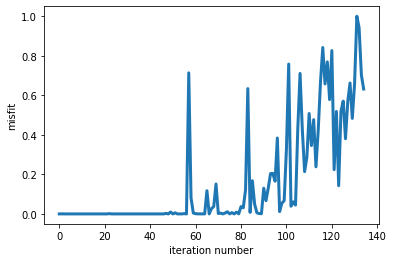

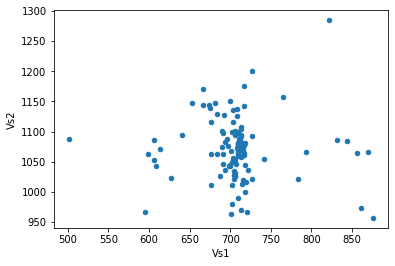

In [11]:
import matplotlib.pyplot as plt

print("Inversion does not converge because of few iteration numbers !!!")

plt.figure()
plt.plot(pchrono_vph/max(pchrono_vph), linewidth = 3)
plt.xlabel("iteration number"); plt.ylabel("misfit")

plt.figure()
plt.xlabel("Vs1"); plt.ylabel("Vs2")
plt.scatter(mo_vph[:,0], mo_vph[:,1], s = 20)

## 3. DTLSWI-DD

DTLSWI using diagram difference as inversion input data. 
1. Ordinal type histogram distance is used to calculate diagram difference of baseline and repeatline.
2. Measured baseline diagram is used in the inversion process to calculate the diagram difference with the synthetic/calculated repeatline at each iteration.
3. The first trace of the measured repeatline seismogram is used as the signal to construct synthetic repeatline at each iteration. In this way, a new offset vector is used in the inversion, witout consideration of the position of the first receiver. 

In [17]:
from math_func import diagram_distance
from NA_inversion import diagram_inversion as dgm_inv

#-> signal to constrcut the synthetic repeatline
repeatline_signal = sismo_c45[:,0]
#-> new offset vector without the first receiver
x_new = x[1:]-x[0]

#-> diagram difference between measured diagrams, used as inversion input data
ORD =  diagram_distance(diagram_c25[:,index], diagram_c25[:,index], finv, v, x[-1]-x[0], distance_type = "ordinary")

#-> with measured diagram
mo_ORD_mes,Pmo_ORD_mes,pchrono_ORD_mes = dgm_inv(ORD,diagram_c25[:,index],repeatline_signal,t,x_new,v,
                                                 mmin,mmax,ni,n0,n1,n2,dns,cvp,f_begin,f_end, 
                                                 distance_type = "ordinary")

Inversion does not converge because of few iteration numbers !!!


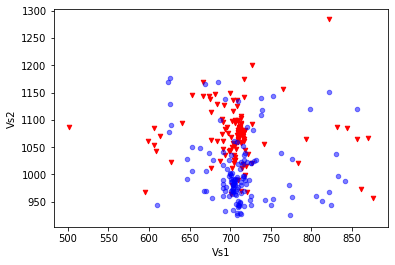

In [18]:
print("Inversion does not converge because of few iteration numbers !!!")

plt.figure()
plt.plot(pchrono_ORD_mes/max(pchrono_ORD_mes), linewidth = 3)
plt.xlabel("iteration number"); plt.ylabel("misfit")

plt.figure()
plt.xlabel("Vs1"); plt.ylabel("Vs2")
plt.scatter(mo_vph[:,0], mo_vph[:,1], s = 20, color = "red", marker = "v")
plt.scatter(mo_ORD_mes[:,0], mo_ORD_mes[:,1], s = 20, color = "blue", marker = "o", alpha = 0.5)